In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy

from scipy.stats import truncnorm, norm

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, Zeros
from tensorflow.keras import backend as K

In [2]:
# reference
# https://github.com/keras-team/keras/blob/d8fcb9d4d4dad45080ecfdd575483653028f8eda/keras/initializers/initializers_v2.py#L973-L1007

def compute_fans(shape):
    receptive_field_size = np.product(shape[:-2])
    fan_in = shape[-2]*receptive_field_size
    fan_out = shape[-1]*receptive_field_size
    return int(fan_in), int(fan_out)

In [200]:
# https://github.com/tensorflow/tensorflow/blob/3f878cff5b698b82eea85db2b60d65a2e320850e/tensorflow/python/ops/random_ops.py#L156-L205

# from tensorflow.python.ops import gen_random_ops
# from tensorflow.python.framework import ops, tensor_util, random_seed

# shape = (50,128)
# mean = 0
# stddev = 1033
# dtype = np.float32
# seed = 42

# shape_tensor = tensor_util.shape_tensor(shape)
# mean_tensor = ops.convert_to_tensor(mean, dtype=dtype, name="mean")
# stddev_tensor = ops.convert_to_tensor(stddev, dtype=dtype, name="stddev")
# seed1, seed2 = random_seed.get_seed(seed)
# rnd = gen_random_ops.truncated_normal(
#     shape_tensor, dtype, seed=seed1, seed2=seed2)
# mul = rnd * stddev_tensor

# Initializers

## Glorot(Xavier) Normal

* **NOTE**: Use **truncated** normal distribution

In [572]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(50,), kernel_initializer=GlorotNormal(seed=32)))
model.add(Dense(2, activation='sigmoid'))

In [573]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 6,786
Trainable params: 6,786
Non-trainable params: 0
_________________________________________________________________


In [574]:
def tnorm_var(a,b,sig, mu=0):
    alpha = (a-mu)/sig
    beta = (b-mu)/sig
    z = norm.cdf(beta, mu, sig) - norm.cdf(alpha, mu, sig)
    pdf_a = norm.pdf(alpha, mu, sig)
    pdf_b = norm.pdf(beta, mu, sig)
    var = np.square(sig)*(1+(alpha*pdf_a - beta*pdf_b)/z - np.square((pdf_a - pdf_b)/z))
    return var

* Glorot Normal ~ truncated normal distribution

$\displaystyle \Huge X \sim \psi(-l,l,0,\sigma) \ \ \normalsize \text{where} \ l=\frac{2\sigma}{\sigma_{1}}, \ \sigma=\sqrt{\frac{2}{fan_{in}+fan_{out}}}, \ \sigma_{1} = \sqrt{\mathrm{Var(X_1)}}, X_1 \sim  \psi(-2,2,\mu=0,\sigma=1)$

In [575]:
fan_in, fan_out = compute_fans(model.layers[0].kernel.shape)

std = np.sqrt(2/(fan_in + fan_out))
print('std:', std)

std: 0.105999788000636


In [576]:
print('* Kernel of dense layer')
print('shape:', model.layers[0].kernel.shape)
print('mean:', model.layers[0].kernel.numpy().mean())
print('std:', model.layers[0].kernel.numpy().std())
print('min:', model.layers[0].kernel.numpy().min())
print('max:', model.layers[0].kernel.numpy().max())

* Kernel of dense layer
shape: (50, 128)
mean: -0.0024922527
std: 0.10565267
min: -0.24037555
max: 0.24049269


In [577]:
kernel_scipy = truncnorm.rvs(-2,2,0,1, size = model.layers[0].kernel.shape)*(std/truncnorm.std(-2,2,0,1))

kernel_keras_backend = K.truncated_normal(model.layers[0].kernel.shape, 0, std/truncnorm.std(-2,2,0,1)).numpy()

In [578]:
print('* calculated by scipy library')
print('shape:', kernel_scipy.shape)
print('mean:', kernel_scipy.mean())
print('std:', kernel_scipy.std())
print('min:', kernel_scipy.min())
print('max:', kernel_scipy.max())

* calculated by scipy library
shape: (50, 128)
mean: 0.0008438618033524522
std: 0.10548582486049132
min: -0.2408497097391207
max: 0.24097291164206106


In [579]:
print('* calculated by keras backend')
print('shape:', kernel_keras_backend.shape)
print('mean:', kernel_keras_backend.mean())
print('std:', kernel_keras_backend.std())
print('min:', kernel_keras_backend.min())
print('max:', kernel_keras_backend.max())

* calculated by keras backend
shape: (50, 128)
mean: -0.0015059266
std: 0.106039174
min: -0.24079686
max: 0.2400082


<br>

`kernel_scipy` vs. `kernel_keras_backend`

In [580]:
print('two input samples are from populations with equal variances:', levene(kernel_scipy.flatten(), kernel_keras_backend.flatten())[1] > .05 )
print('two input samples have identical average values:', ttest_ind(kernel_scipy.flatten(), kernel_keras_backend.flatten())[1] > .05 )

two input samples are from populations with equal variances: True
two input samples have identical average values: True


`kernel_keras_backend` vs. `model.layers[0].kernel`(w/ `GlorotNormal`)

In [581]:
print('two input samples are from populations with equal variances:', levene(kernel_keras_backend.flatten(), model.layers[0].kernel.numpy().flatten())[1] > .05 )
print('two input samples have identical average values:', ttest_ind(kernel_keras_backend.flatten(), model.layers[0].kernel.numpy().flatten())[1] > .05 )

two input samples are from populations with equal variances: True
two input samples have identical average values: True


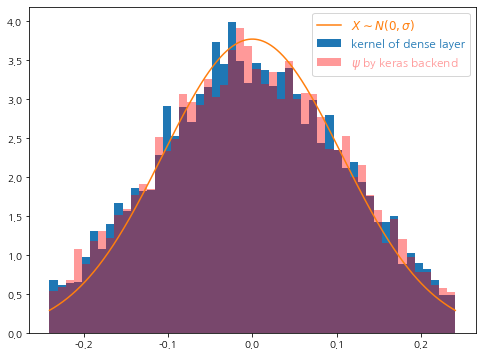

In [584]:
plt.figure(figsize=(8,6))
_, bins, _ = plt.hist(model.layers[0].kernel.numpy().flatten(), density=True, bins=50, label = 'kernel of dense layer')
plt.hist(kernel_keras_backend.flatten(), density=True, bins=bins, alpha=.4, label = r'$\psi$ by keras backend', color='r')

norm_x = np.linspace(bins[0], bins[-1], 1000)
norm_y = norm.pdf(norm_x, loc=0, scale = std)
plt.plot(norm_x, norm_y, label = r'$X\sim N(0,\sigma)$')

plt.legend(fontsize=12, labelcolor='linecolor')
plt.show()

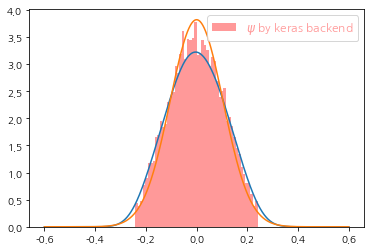

In [571]:
from sklearn.neighbors import KernelDensity

counts, bins, _ = plt.hist(kernel_keras_backend.flatten(), density=True, bins=50, alpha=.4, label = r'$\psi$ by keras backend', color='r')
# plt.scatter(bins[1:], counts,  s=3)

kde = KernelDensity(kernel='gaussian', bandwidth=.05).fit(kernel_keras_backend.flatten().reshape(-1,1))
# plt.plot(np.linspace(-.3,.3,1000).reshape(-1,1), np.exp(kde.score_samples(np.linspace(-.3,.3,1000).reshape(-1,1))) )
plt.plot(np.linspace(-.6,.6,1000), np.exp(kde.score_samples(np.linspace(-.6,.6,1000).reshape(-1,1))) )

norm_std = 0.10446543
plt.plot(np.linspace(-.6,.6,1000), norm.pdf(np.linspace(-.6,.6,1000), 0, norm_std))

plt.legend(fontsize=12, labelcolor='linecolor')
plt.show()

## Glorot(Xavier) Uniform

* Glorot Normal ~ Uniform distribution

$\displaystyle \Huge X \sim U(-l, l) \ \ \normalsize \text{where} \ l=\sqrt{\frac{6}{fan_{in}+fan_{out}}}$

In [503]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(50,), kernel_initializer=GlorotUniform(seed=32)))
model.add(Dense(2, activation='sigmoid'))

In [504]:
fan_in, fan_out = compute_fans(model.layers[0].kernel.shape)

limit = np.sqrt(6/(fan_in + fan_out))
print('limit:', limit)

limit: 0.18359701840863138


In [505]:
print('* Kernel of dense layer')
print('shape:', model.layers[0].kernel.shape)
print('mean:', model.layers[0].kernel.numpy().mean())
print('std:', model.layers[0].kernel.numpy().std())
print('min:', model.layers[0].kernel.numpy().min())
print('max:', model.layers[0].kernel.numpy().max())

* Kernel of dense layer
shape: (50, 128)
mean: 0.00025605928
std: 0.10581555
min: -0.18358538
max: 0.18355618


In [506]:
print('Uniform distribution on [-limit, limit]')
print('mean:', uniform.mean(-limit, 2*limit))
print('std:', uniform.std(-limit, 2*limit))
uniform_scipy = uniform.rvs(-limit, 2*limit, size = model.layers[0].kernel.shape)
print('min:',uniform_scipy.min())
print('max:', uniform_scipy.max())

Uniform distribution on [-limit, limit]
mean: 0.0
std: 0.105999788000636
min: -0.18354511330146997
max: 0.18334843212296828


<br>

`kernel_scipy` vs. `model.layers[0].kernel`(w/ `GlorotUniform`)

In [517]:
print('two input samples are from populations with equal variances:', levene(uniform_scipy.flatten(), model.layers[0].kernel.numpy().flatten())[1] > .05 )
print('two input samples have identical average values:', ttest_ind(uniform_scipy.flatten(), model.layers[0].kernel.numpy().flatten())[1] > .05 )

two input samples are from populations with equal variances: True
two input samples have identical average values: True


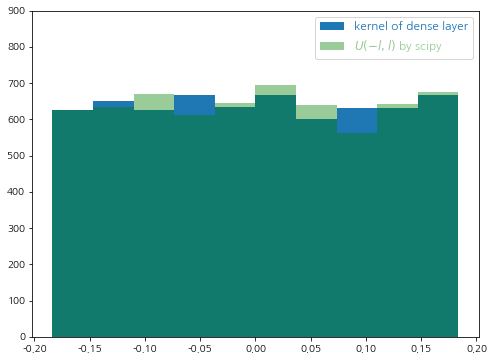

In [516]:
plt.figure(figsize=(8,6))
plt.ylim(0,900)
_, bins, _ = plt.hist(model.layers[0].kernel.numpy().flatten(), bins=10, label = 'kernel of dense layer')
plt.hist(uniform_scipy.flatten(), bins=bins, alpha=.4, label = r'$U(-l,l)$ by scipy', color='g')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.show()